# BÀI THỰC HÀNH 2 – GIẢI THUẬT 2 (SVM)  
**Bài toán:** Dự đoán độ nguy hiểm của động vật trong rừng


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# 2. Đọc dữ liệu

In [6]:
# ======================================================
# 2. Đọc dữ liệu
# ======================================================

df = pd.read_csv("data.csv")

print("Kích thước dữ liệu:", df.shape)
df.head()


Kích thước dữ liệu: (871, 7)


AnimalName symptoms1             symptoms2 symptoms3    symptoms4  \
0        Dog     Fever              Diarrhea  Vomiting  Weight loss   
1        Dog     Fever              Diarrhea  Coughing    Tiredness   
2        Dog     Fever              Diarrhea  Coughing     Vomiting   
3        Dog     Fever  Difficulty breathing  Coughing     Lethargy   
4        Dog     Fever              Diarrhea  Coughing     Lethargy   

     symptoms5 Dangerous  
0  Dehydration       Yes  
1        Pains       Yes  
2     Anorexia       Yes  
3     Sneezing       Yes  
4     Blue Eye       Yes

Dữ liệu được đọc từ file `animal.csv` với kích thước:

- **871 mẫu**, **7 thuộc tính**:

| Cột          | Ý nghĩa                             |
|--------------|--------------------------------------|
| AnimalName   | Tên loài động vật                   |
| symptoms1    | Triệu chứng 1                       |
| symptoms2    | Triệu chứng 2                       |
| symptoms3    | Triệu chứng 3                       |
| symptoms4    | Triệu chứng 4                       |
| symptoms5    | Triệu chứng 5                       |
| Dangerous    | Nhãn: động vật nguy hiểm hay không |

# 3. Khám phá sơ bộ dữ liệu

In [7]:
# ======================================================
# 3. Khám phá sơ bộ dữ liệu
# ======================================================

print(df.info())
print("\nThống kê mô tả các cột số:")
print(df.describe(include="all"))

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AnimalName  871 non-null    object
 1   symptoms1   871 non-null    object
 2   symptoms2   871 non-null    object
 3   symptoms3   871 non-null    object
 4   symptoms4   871 non-null    object
 5   symptoms5   871 non-null    object
 6   Dangerous   869 non-null    object
dtypes: object(7)
memory usage: 47.8+ KB
None

Thống kê mô tả các cột số:
       AnimalName symptoms1 symptoms2 symptoms3    symptoms4 symptoms5  \
count         871       871       871       871          871       871   
unique         46       232       230       229          217       203   
top     Buffaloes     Fever  Diarrhea  Coughing  Weight loss     Pains   
freq          129       257       119        95          117        99   

       Dangerous  
count        869  
unique         2  
top          Yes  
freq         84

Kết quả `df.info()` và `describe()`:

- 7 cột đều ở kiểu **object** (chuỗi).  
- Cột `Dangerous` có **869** giá trị, thiếu **2** giá trị.

In [8]:
# (Tuỳ chọn) Vẽ biểu đồ phân bố lớp Dangerous (Yes / No)
plt.figure(figsize=(4, 4))
df['Dangerous'].value_counts().plot(kind='bar')
plt.title("Phân bố nhãn Dangerous (Yes/No)")
plt.xlabel("Dangerous")
plt.ylabel("Số lượng")
plt.show()


### Phân bố nhãn

Biểu đồ cột cho `Dangerous` cho thấy:

- Số mẫu **“Yes” (nguy hiểm)** chiếm đa số (hơn 800 mẫu).  
- Số mẫu **“No” (không nguy hiểm)** rất ít (vài chục mẫu).

=> Dữ liệu **rất mất cân bằng** giữa 2 lớp.

---

# 4. Làm sạch & tiền xử lý

In [9]:
# ======================================================
# 4. Làm sạch & tiền xử lý
# ======================================================

# 4.1. Xử lý giá trị thiếu: bỏ những dòng bị thiếu (nếu có)
df = df.dropna()

# 4.2. Chuẩn hoá tên AnimalName cho gọn (strip khoảng trắng, gộp 1 số tên)
df['AnimalName'] = df['AnimalName'].str.strip()
df['AnimalName'] = df['AnimalName'].replace({
    'Black-tailed deer': 'Deer',
    'White-tailed deer': 'Deer',
    'Dogs': 'Dog',
    'Goats': 'Goat',
    'Fox ': 'Fox'
})

# 4.3. Mã hoá các cột dạng chuỗi bằng LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

df.head()


AnimalName  symptoms1  symptoms2  symptoms3  symptoms4  symptoms5  \
0           5         63         30        179        181         32   
1           5         63         30         31        164        113   
2           5         63         30         31        172          8   
3           5         63         33         31         87        142   
4           5         63         30         31         87         21   

   Dangerous  
0          1  
1          1  
2          1  
3          1  
4          1

1. **Xử lý giá trị thiếu**

   - Vì cột `Dangerous` có 2 giá trị thiếu nên bỏ các dòng tương ứng bằng `dropna()` để dữ liệu sạch.

2. **Chuẩn hoá dữ liệu cho SVM và KNN**

   - Sử dụng `StandardScaler` để chuẩn hoá các feature:
     - `X_train_scaled = scaler.fit_transform(X_train)`
     - `X_test_scaled  = scaler.transform(X_test)`

3. **Mã hoá biến phân loại**

   - Tất cả các cột (`AnimalName`, `symptoms1`–`symptoms5`, `Dangerous`) đều là chuỗi nên được mã hoá bằng `LabelEncoder`.
   - Sau mã hoá, mỗi giá trị khác nhau được gán một số nguyên (0, 1, 2, …).

# 5. Tách features / label và chia train / test

In [ ]:
# ======================================================
# 5. Tách features / label và chia train / test
#    - Giả sử cột nhãn là 'Dangerous'
# ======================================================

X = df.drop('Dangerous', axis=1)
y = df['Dangerous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=90,
    stratify=y
)

print("Kích thước tập train:", X_train.shape)
print("Kích thước tập test :", X_test.shape)


Kích thước tập train: (651, 6)
Kích thước tập test : (218, 6)


### **Tách tập train / test**

   - Chọn **`Dangerous`** làm nhãn (`y`), 6 cột còn lại làm đặc trưng (`X`).  
   - Chia dữ liệu với `train_test_split`:

     - Train: **651 mẫu**, 6 features  
     - Test : **218 mẫu**, 6 features  
     - `test_size = 0.25`, `random_state = 90`, `stratify = y`.


# 6. Mô hình SVM (kernel tuyến tính)
- Chuẩn hoá feature bằng StandardScaler

In [11]:
# ======================================================
# 6. Mô hình SVM (kernel tuyến tính)
#    - Chuẩn hoá feature bằng StandardScaler
# ======================================================

scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)

svm_clf = SVC(
    kernel='linear',   # giống code mẫu
    C=1.0,
    random_state=0
)

# Huấn luyện
svm_clf.fit(X_train_svm, y_train)

# Dự đoán
y_pred_svm = svm_clf.predict(X_test_svm)

print("========== SVM (linear kernel) ==========")
print("Accuracy trên tập test:", round(accuracy_score(y_test, y_pred_svm), 4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification report:")
print(classification_report(y_test, y_pred_svm))


========== SVM (linear kernel) ==========
Accuracy trên tập test: 0.9771

Confusion matrix:
[[  0   5]
 [  0 213]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.98      1.00      0.99       213

    accuracy                           0.98       218
   macro avg       0.49      0.50      0.49       218
weighted avg       0.95      0.98      0.97       218



c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 3.1. Cấu hình

Mô hình:

```python
SVC(kernel='linear', C=1.0, random_state=0)
```
Được huấn luyện trên X_train_scaled, y_train và đánh giá trên X_test_scaled.

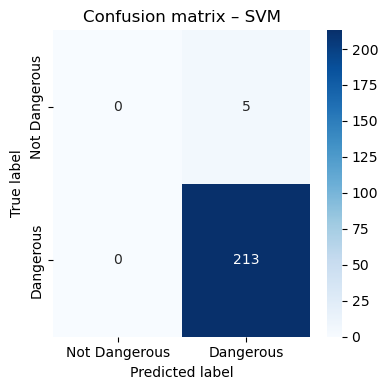

In [12]:
# (Tuỳ chọn) Vẽ confusion matrix cho SVM

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Dangerous', 'Dangerous'],
            yticklabels=['Not Dangerous', 'Dangerous'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix – SVM")
plt.tight_layout()
plt.show()


## Kết quả

### 🎯 Accuracy trên tập test
- **Accuracy:** 0.9771 ≈ **97.71%**

---

## 📊 Confusion Matrix (SVM)

|               | Dự đoán 0 | Dự đoán 1 |
|---------------|-----------|-----------|
| **Thực tế 0** |     0     |     5     |
| **Thực tế 1** |     0     |   213     |

- Có **5 mẫu thực tế “Không nguy hiểm (0)”** bị dự đoán nhầm thành **“Nguy hiểm (1)”** → *False Positive (FP = 5)*  
- Có **0 mẫu “Không nguy hiểm” được dự đoán đúng** → *True Negative (TN = 0)*  
- Tất cả **213 mẫu “Nguy hiểm (1)”** đều được dự đoán đúng → *True Positive (TP = 213)*

---

## 📈 Classification Report (SVM)

### Lớp 0 – Không nguy hiểm
- **Precision:** 0.00  
- **Recall:** 0.00  
- **F1-score:** 0.00  
- **Support:** 5  

### Lớp 1 – Nguy hiểm
- **Precision:** 0.98  
- **Recall:** 1.00  
- **F1-score:** 0.99  
- **Support:** 213  

### Tổng thể
- **Accuracy:** 0.98  
- **Macro avg:** Precision 0.49 – Recall 0.50 – F1 0.49  
- **Weighted avg:** Precision 0.95 – Recall 0.98 – F1 0.97  

---

## 📝 Nhận xét mô hình SVM

- Mô hình **luôn dự đoán "Nguy hiểm" (lớp 1)** cho mọi mẫu trong tập test.
- Nguyên nhân:  
  - Tập dữ liệu **lệch lớp mạnh** (213 mẫu nguy hiểm vs 5 mẫu không nguy hiểm).  
  - SVM chọn ranh giới phân lớp khiến toàn bộ điểm bị đẩy sang phía lớp 1.

### ✔️ Ưu điểm
- **Không bỏ sót động vật nguy hiểm nào**  
  → Recall lớp 1 = **1.00**

### ✘ Nhược điểm
- **Không phát hiện được lớp “Không nguy hiểm”**  
  → Recall lớp 0 = **0.00**

### 📌 Ghi chú quan trọng
- Accuracy vẫn **rất cao (97.71%)** nhưng **mang tính đánh lừa**, vì dữ liệu mất cân bằng:
  - Chỉ cần đoán tất cả là “Nguy hiểm” cũng đúng phần lớn.

---


# 7. Mô hình KNN 

In [ ]:
# ======================================================
# 7. Mô hình KNN 
# ======================================================

# Dùng lại StandardScaler (hoặc tạo scaler mới tuỳ ý)
X_train_knn = scaler.fit_transform(X_train)
X_test_knn = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_knn, y_train)
y_pred_knn = knn.predict(X_test_knn)

print("========== KNN (k=3) ==========")
print("Accuracy trên tập test:", round(accuracy_score(y_test, y_pred_knn), 4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nClassification report:")
print(classification_report(y_test, y_pred_knn))


========== KNN (k=3) ==========
Accuracy trên tập test: 0.9725

Confusion matrix:
[[  0   5]
 [  1 212]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.98      1.00      0.99       213

    accuracy                           0.97       218
   macro avg       0.49      0.50      0.49       218
weighted avg       0.95      0.97      0.96       218



**Mô hình:**

```python
KNeighborsClassifier(n_neighbors=3)
```
---
**Kết quả**

**Accuracy trên tập test:** 0.9725 ≈ 97.25%

**Confusion matrix (KNN):**

| Actual \ Predicted |    0    |   1    |
|--------------------|---------|--------|
| **0**              |    0    |   5    |
| **1**              |    1    |  212   |

- 5 mẫu “Không nguy hiểm” vẫn bị dự đoán thành “Nguy hiểm”.
- 212/213 mẫu “Nguy hiểm” được dự đoán đúng; còn 1 mẫu “Nguy hiểm” bị dự đoán nhầm thành “Không nguy hiểm”.
---
**Classification report (KNN):**

**Lớp 0 – Không nguy hiểm**
- Precision: 0.00  
- Recall: 0.00  
- F1-score: 0.00  
- Support: 5  

**Lớp 1 – Nguy hiểm**
- Precision: 0.98  
- Recall: 1.00  
- F1-score: 0.99  
- Support: 213  
---
**Accuracy:** 0.97  

**Macro avg:** Precision 0.49 – Recall 0.50 – F1 0.49  
**Weighted avg:** Precision 0.95 – Recall 0.97 – F1 0.96  

---
**Nhận xét KNN:**  
- Hành vi khá giống SVM: gần như luôn dự đoán “Nguy hiểm”.  
- Chỉ khác là KNN bỏ sót 1 mẫu “Nguy hiểm” (FN = 1), nên accuracy thấp hơn SVM một chút.


In [14]:
# So sánh nhanh accuracy SVM vs KNN

acc_svm = accuracy_score(y_test, y_pred_svm)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"Accuracy SVM : {acc_svm:.4f}")
print(f"Accuracy KNN : {acc_knn:.4f}")

if acc_svm > acc_knn:
    print("=> SVM cho kết quả tốt hơn KNN trên tập test.")
elif acc_svm < acc_knn:
    print("=> KNN cho kết quả tốt hơn SVM trên tập test.")
else:
    print("=> SVM và KNN cho độ chính xác tương đương nhau.")


Accuracy SVM : 0.9771
Accuracy KNN : 0.9725
=> SVM cho kết quả tốt hơn KNN trên tập test.


## 5. So sánh SVM và KNN

### **Tổng hợp độ chính xác**
- **Accuracy SVM:** 0.9771  
- **Accuracy KNN:** 0.9725  

➡️ **SVM cho kết quả tốt hơn KNN** trên tập test (cao hơn ≈ 0.5%).

### **Ảnh hưởng của dữ liệu mất cân bằng**
Do dữ liệu cực kỳ mất cân bằng (rất ít mẫu “Không nguy hiểm”), cả SVM và KNN đều:

- Hầu như **không học được lớp “Không nguy hiểm”** → Precision/Recall/F1 của lớp 0 = **0**.
- Chủ yếu tập trung vào việc nhận diện lớp “Nguy hiểm”.
- Do đó, **accuracy cao không phản ánh đúng chất lượng mô hình** cho cả hai lớp.

### **Cải thiện mô hình trong trường hợp thực tế**
Nếu bài toán yêu cầu phân biệt rõ hai lớp “Nguy hiểm” và “Không nguy hiểm”, cần:

- **Thu thập thêm mẫu** cho lớp “Không nguy hiểm”.
- **Áp dụng kỹ thuật xử lý mất cân bằng** như:
  - Oversampling (SMOTE, Random Oversampling)
  - Class weighting
  - Undersampling lớp lớn

---

# Kết luận

### **Tóm tắt mô hình**
Bài thực hành đã triển khai thành công 2 mô hình:

- **SVM** (kernel tuyến tính)  
- **KNN** (k = 3)  

trên bộ dữ liệu dự đoán độ nguy hiểm của động vật.

### **Hiệu quả mô hình**
- Cả hai mô hình đều đạt **Accuracy > 97%**  
- Trong đó **SVM nhỉnh hơn KNN**

### **Vấn đề của dữ liệu lệch lớp**
Do dữ liệu không cân bằng:

- Mô hình **học rất tốt lớp “Nguy hiểm”**
- Nhưng **gần như bỏ qua lớp “Không nguy hiểm”**

### **Đề xuất cho thực tế**
Để mô hình hữu ích hơn, cần:

- **Cân bằng lại dữ liệu** giữa hai lớp  
- **Sử dụng các tiêu chí đánh giá phù hợp hơn**, như:
  - Recall và F1-score của từng lớp
  - Precision–Recall Curve
  - ROC–AUC  